In [15]:
import warnings
warnings.filterwarnings(action="default")

In [16]:
# imports
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras

import numpy as np
import matplotlib.pyplot as plt


/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [18]:
x_train = (x_train - 127.5)/127.5

print(x_train.min())
print(x_train.max())

-1.0
1.0


In [19]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
HALF_BATCH = int(BATCH_SIZE/2)

NO_OF_BATCHES = int(x_train.shape[0]/BATCH_SIZE)

NOISE_DIM = 100
adam = Adam(learning_rate = 2e-4, beta_1=0.5)

# Generator Model

In [20]:
generator = Sequential()
generator.add(Dense(units= 7*7*128, input_shape = (NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, (3,3), strides = (2,2), padding = 'same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(1, (3,3), strides=(2,2), padding='same', activation='tanh'))
generator.compile(loss = keras.losses.binary_crossentropy, optimizer = adam)

generator.summary()

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:538: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)       

# Descriminator Model

In [21]:
descriminator = Sequential()
descriminator.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', input_shape = (28,28,1)))
descriminator.add(LeakyReLU(0.2))

descriminator.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same'))
descriminator.add(LeakyReLU(0.2))

descriminator.add(Flatten())
descriminator.add(Dense(100))
descriminator.add(LeakyReLU(0.2))

descriminator.add(Dense(1, activation='sigmoid'))
descriminator.compile(loss = keras.losses.binary_crossentropy, optimizer = adam)

descriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               627300    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 100)              

In [22]:
Input(shape = [NOISE_DIM])

<tf.Tensor 'input_4:0' shape=(?, 100) dtype=float32>

# Combined Model

In [23]:
descriminator.trainable = False

gan_input = Input(shape = [NOISE_DIM])

generated_img = generator(gan_input)

gan_output = descriminator(generated_img)

model = Model(gan_input, gan_output)
model.compile(loss = keras.losses.binary_crossentropy, optimizer = adam)

In [24]:
x_train = x_train.reshape(-1,28,28,1)

In [25]:
x_train.shape

(60000, 28, 28, 1)

In [26]:
def display_images(samples = 25):
  noise = np.random.normal(0,1,size = (samples, NOISE_DIM))

  generated_img = generator.predict(noise)

  plt.figure(figsize = (10,10))
  for i in range(samples):
    plt.subplot(5,5,i+1)
    plt.imshow(generated_img[i].reshape(28,28), cmap = "binary")
    plt.axis('off')
  plt.show()

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:538: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/opt/anaconda3/envs/dev/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:538: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/opt/anaconda3/envs/dev/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:538: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1, Disc loss 0.21574794653556598, Generator loss 0.9979011579456493
Epoch 2, Disc loss 0.5586961727513748, Generator loss 1.9351783461040921
Epoch 3, Disc loss 0.5871494364025246, Generator loss 1.5412459398946192
Epoch 4, Disc loss 0.6179376126099856, Generator loss 1.4542328552303152
Epoch 5, Disc loss 0.6607466784552631, Generator loss 1.2525911764201956
Epoch 6, Disc loss 0.6644186703567831, Generator loss 1.1336805331401336
Epoch 7, Disc loss 0.661236353409596, Generator loss 1.085308566562131
Epoch 8, Disc loss 0.6604312719442905, Generator loss 1.0617725854246025
Epoch 9, Disc loss 0.6579565408392849, Generator loss 1.0479894020618536
Epoch 10, Disc loss 0.6563044856501441, Generator loss 1.0497055038427696


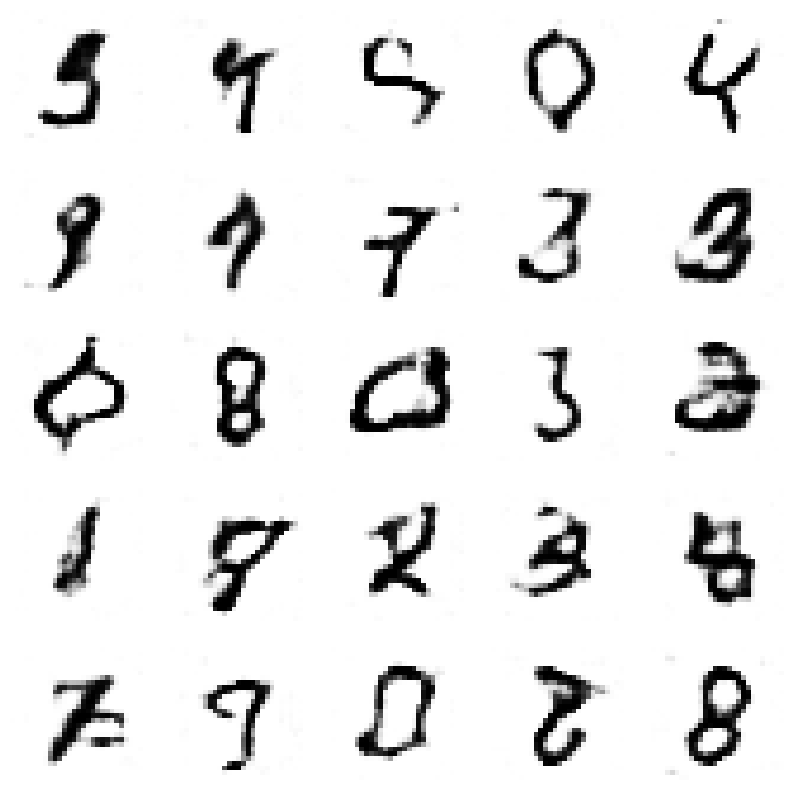

Epoch 11, Disc loss 0.6531460716938361, Generator loss 1.0526284898957636
Epoch 12, Disc loss 0.652425016475539, Generator loss 1.058206353432093
Epoch 13, Disc loss 0.6479246895282696, Generator loss 1.066872958953564
Epoch 14, Disc loss 0.6459840831593571, Generator loss 1.0821321795129368
Epoch 15, Disc loss 0.6421949478168772, Generator loss 1.0894680267725236
Epoch 16, Disc loss 0.6400544254316224, Generator loss 1.1054587557784512
Epoch 17, Disc loss 0.6373271563878427, Generator loss 1.1158686606293051
Epoch 18, Disc loss 0.6341410088233459, Generator loss 1.134150828051771
Epoch 19, Disc loss 0.6293348587858372, Generator loss 1.150359754378979
Epoch 20, Disc loss 0.6277399242688448, Generator loss 1.1631580509691157


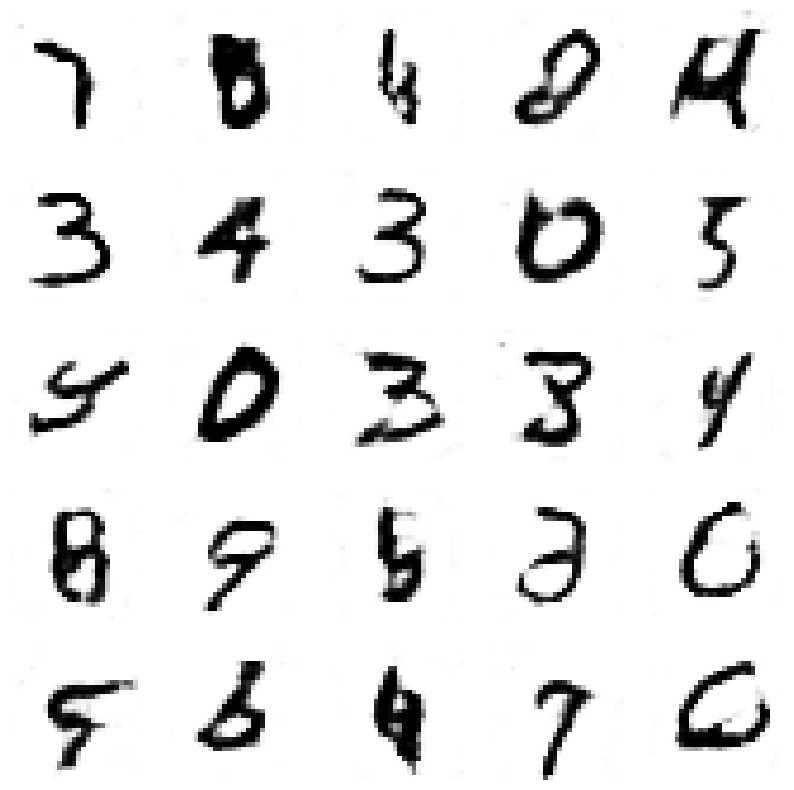

Epoch 21, Disc loss 0.6255602207448747, Generator loss 1.178725241086422
Epoch 22, Disc loss 0.6221111853662719, Generator loss 1.1985723870432274
Epoch 23, Disc loss 0.6184389856126573, Generator loss 1.210421344663343
Epoch 24, Disc loss 0.6133109545096372, Generator loss 1.229013893339369
Epoch 25, Disc loss 0.611493311695054, Generator loss 1.2439992224049365
Epoch 26, Disc loss 0.6065271023629059, Generator loss 1.2606468654086447
Epoch 27, Disc loss 0.6044782770113049, Generator loss 1.280131534124032
Epoch 28, Disc loss 0.6017803269573766, Generator loss 1.2914745848403018
Epoch 29, Disc loss 0.5971019322164038, Generator loss 1.3153269224696689
Epoch 30, Disc loss 0.5937573907212315, Generator loss 1.3319739179733472


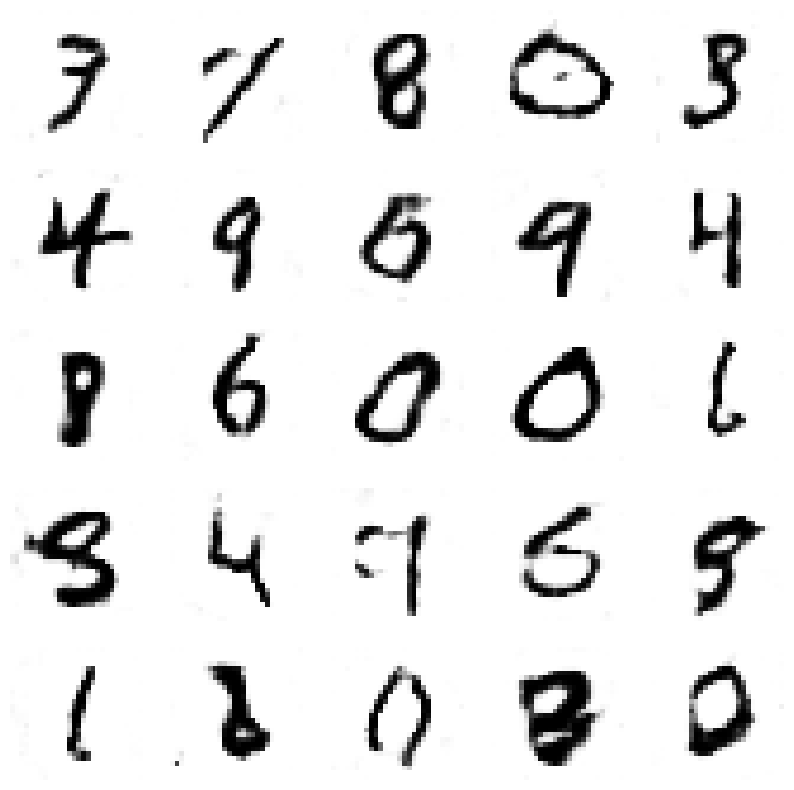

Epoch 31, Disc loss 0.5899649455379217, Generator loss 1.3519234713326154
Epoch 32, Disc loss 0.584639468890989, Generator loss 1.3727756412620218
Epoch 33, Disc loss 0.581219261782801, Generator loss 1.3884000187246208
Epoch 34, Disc loss 0.578417468465801, Generator loss 1.4088374559695904
Epoch 35, Disc loss 0.5736099750949786, Generator loss 1.426932506581657
Epoch 36, Disc loss 0.5694295330944225, Generator loss 1.4514239522127004
Epoch 37, Disc loss 0.5689384289658986, Generator loss 1.4693530935507555
Epoch 38, Disc loss 0.5639005935727022, Generator loss 1.4881939842150762
Epoch 39, Disc loss 0.5614594238945562, Generator loss 1.509211331860632
Epoch 40, Disc loss 0.559157855108253, Generator loss 1.5245660069661262


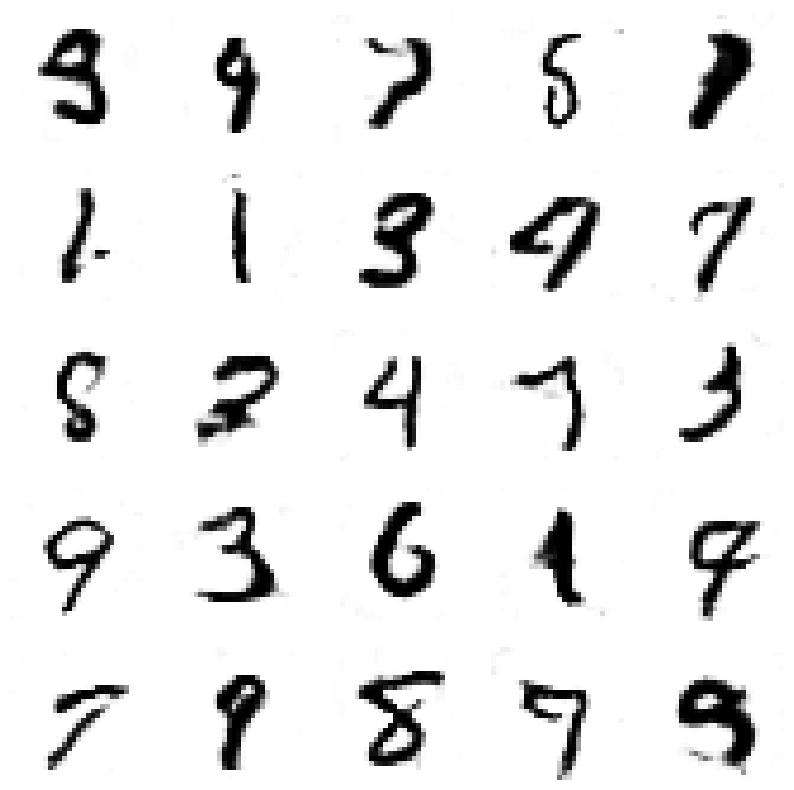

In [ ]:
d_losses = []
g_losses = []

for epoch in range(TOTAL_EPOCHS):
  epoch_d_loss = 0.0
  epoch_g_loss = 0.0

  for step in range(NO_OF_BATCHES):
    # Train Descriminator
    descriminator.trainable = True

    idx = np.random.randint(0, 60000, HALF_BATCH)
    real_imgs = x_train[idx]

    noise = np.random.normal(0,1, size = (HALF_BATCH, NOISE_DIM))
    fake_imgs = generator.predict(noise)

    real_y = np.ones((HALF_BATCH, 1))*0.9
    fake_y = np.zeros((HALF_BATCH, 1))

    d_loss_real = descriminator.train_on_batch(real_imgs, real_y)
    d_loss_fake = descriminator.train_on_batch(fake_imgs, fake_y)

    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake

    epoch_d_loss += d_loss

    # Train Generator
    descriminator.trainable = False
    noise = np.random.normal(0,1,size = (BATCH_SIZE, NOISE_DIM))
    ground_truth_y = np.ones((BATCH_SIZE, 1))
    
    g_loss = model.train_on_batch(noise, ground_truth_y)
    epoch_g_loss += g_loss

  print(f"Epoch {epoch+1}, Disc loss {epoch_d_loss/NO_OF_BATCHES}, Generator loss {epoch_g_loss/NO_OF_BATCHES}")

  d_losses.append(epoch_d_loss/NO_OF_BATCHES)
  g_losses.append(epoch_g_loss/NO_OF_BATCHES)

  if(epoch+1)%10 == 0:
    generator.save("generator.h5")
    display_images()